# Leer las ondas
1) Imports

In [34]:
%load_ext oct2py.ipython
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
#para el tiempo
from datetime import datetime
import pandas as pd
octave.addpath('/home/scidb/HeartRatePatterns/Matlab/')
octave.eval('pkg load signal')

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


Leer la base de datos para decidir que Ondas vamos a traer

In [33]:
def obtainWaveFormFields(dbname="mimic") :
    labels='II'
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "SELECT lef.subject_id,lef.recorddate,lef.signame,lef.fs FROM waveformfields lef  LEFT JOIN (SELECT MAX(recorddate) AS recorddate,subject_id FROM waveformFields GROUP BY subject_id) rig ON lef.subject_id = rig.subject_id AND lef.recorddate = rig.recorddate WHERE rig.subject_id IS NOT NULL AND signame @> ARRAY['"+labels+"']::varchar[]"
    cur.execute(select_stament)
    waves = []
    for row in cur :
        patient = "p"+str(row[0]).zfill(6)
        onda = patient+'-'+row[1]
        carpeta = patient[:3]+"/"+patient
        waves.append({"subject_id":row[0],"recorddate":row[1],"fs":row[3],"onda":onda,"carpeta":carpeta,
                      "signalII":row[2].index("II")})
    conn.close()
    return waves
carpeta = waves[0]["carpeta"]
onda = waves[0]["onda"]
signalII = waves[0]["signalII"]
fs = waves[0]["fs"]
subject_id = waves[0]["subject_id"]
recorddate = waves[0]["recorddate"]

In [3]:
signal = wfdb.rdsamp(onda,pbdir='mimic3wdb/matched/'+carpeta,channels =[signalII]).p_signals
subsignal = signal[-1800000:,0].tolist()
len("La señal tiene ",signal," registros extraemos las ultimas 4 horas")

Extraemos las ultimas 4 horas osea 1'800.000 registros

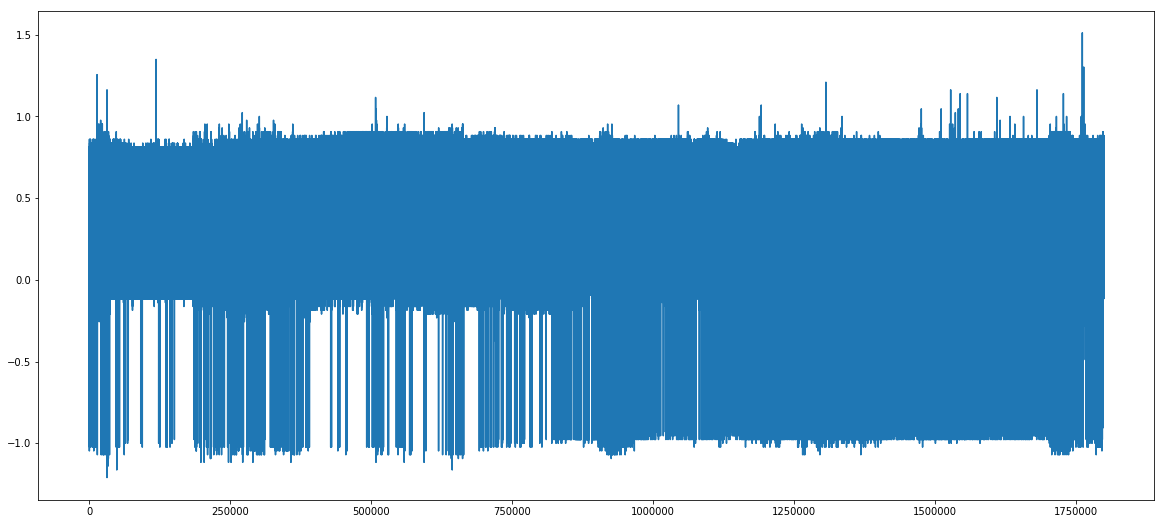

In [6]:
fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(subsignal)
#plt.plot(signal[:,1])
plt.show()

In [8]:
def peakdetect(signal, fs,increment=0,previousResult=None):
    if previousResult is None:
        previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    %octave [R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot] = peakdetect(signal,fs,false); -i signal,fs -o R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot
    return {'Q_i'  :np.concatenate((previousResult['Q_i'],  Q_i[0]+increment)),
            'Q_amp':np.concatenate((previousResult['Q_amp'],Q_amp[0])),
            'R_i'  :np.concatenate((previousResult['R_i'],  R_i[0]+increment)),
            'R_amp':np.concatenate((previousResult['R_amp'],R_amp[0])),
            'S_i'  :np.concatenate((previousResult['S_i'],  S_i[0]+increment)),
            'S_amp':np.concatenate((previousResult['S_amp'],S_amp[0])),
            'T_i'  :np.concatenate((previousResult['T_i'],  T_i[0]+increment)),
            'T_amp':np.concatenate((previousResult['T_amp'],T_amp[0])),
           }

In [35]:
windowsize = 1000*fs
first = peakdetect(subsignal[0:windowsize],fs)
second = peakdetect(subsignal[windowsize:windowsize*2],fs,increment=init,previousResult=first)
print(second)

{'R_i': array([  6.50000000e+01,   1.64000000e+02,   2.64000000e+02, ...,
         1.24835000e+05,   1.24928000e+05,   1.25021000e+05]), 'R_amp': array([ 0.48837209,  0.48837209,  0.46511628, ...,  0.46511628,
        0.46511628,  0.48837209]), 'Q_amp': array([-0.04186047, -0.06511628, -0.10697674, ..., -0.09767442,
       -0.10697674, -0.06511628]), 'Q_i': array([  6.00000000e+01,   1.59000000e+02,   2.59000000e+02, ...,
         1.24830000e+05,   1.24923000e+05,   1.25016000e+05]), 'T_amp': array([ 0.10697674,  0.06511628,  0.0744186 , ...,  0.07906977,
        0.05581395,  0.08372093]), 'T_i': array([  1.05000000e+02,   2.05000000e+02,   3.05000000e+02, ...,
         1.24784000e+05,   1.24875000e+05,   1.24968000e+05]), 'S_i': array([  7.60000000e+01,   1.75000000e+02,   2.75000000e+02, ...,
         1.24844000e+05,   1.24938000e+05,   1.25032000e+05]), 'S_amp': array([-0.07906977, -0.09767442, -0.11627907, ..., -0.10697674,
       -0.09767442, -0.07906977])}


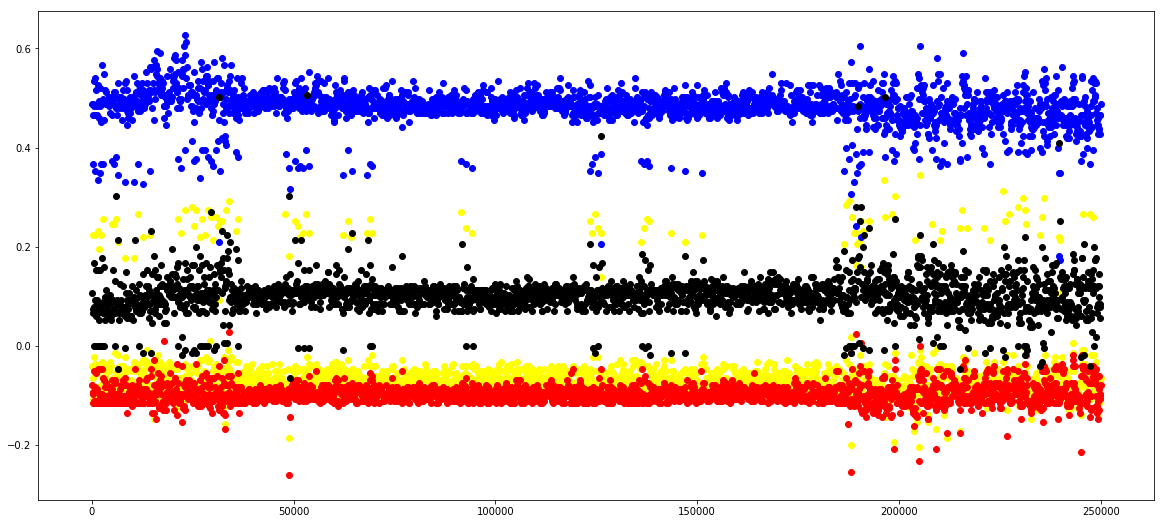

In [11]:
#plt.plot(subsignal[0:end],c='lightgreen')
plt.scatter(second['Q_i'], second['Q_amp'],c='yellow')
plt.scatter(second['R_i'], second['R_amp'],c='blue')
plt.scatter(second['S_i'], second['S_amp'],c='red')
plt.scatter(second['T_i'], second['T_amp'],c='black')
plt.show()

In [36]:
def audit(now = datetime.now()):
    print("hasta aqui van",(now-before))
    return now
def checkwave(signal,fs):
    now = audit()
    windowsize = 1000*fs
    signalsize = len(signal)
    previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    termino = True
    fin=0
    while termino:
        ini=fin
        fin=fin+ (windowsize)
        if(fin>signalsize):
            fin=signalsize
        now = audit(now)
        previousResult = peakdetect(signal[ini:fin],fs,increment=ini,previousResult=previousResult)
        now = audit(now)
        termino = fin<signalsize
    return previousResult

In [13]:
previousResult = checkwave(subsignal,fs)
previousResult

inicio 2017-09-24 04:29:31.476186
signal size 1800000 fs 125 windowsize 125000
hasta aqui van 0:00:00.001231


hasta aqui van 0:00:32.139460
Q 1169
R 1169
S 1169
T 1156
peackdetect ini: 0 fin 125000
hasta aqui van 0:00:00.001808


hasta aqui van 0:00:32.427405
Q 2383
R 2383
S 2383
T 2358
peackdetect ini: 125000 fin 250000
hasta aqui van 0:00:00.001560


hasta aqui van 0:00:33.905120
Q 3598
R 3598
S 3598
T 3538
peackdetect ini: 250000 fin 375000
hasta aqui van 0:00:00.002911


hasta aqui van 0:00:35.508491
Q 4713
R 4713
S 4713
T 4644
peackdetect ini: 375000 fin 500000
hasta aqui van 0:00:00.001972


hasta aqui van 0:00:33.922785
Q 5828
R 5828
S 5828
T 5749
peackdetect ini: 500000 fin 625000
hasta aqui van 0:00:00.002083


hasta aqui van 0:00:33.114928
Q 6949
R 6949
S 6949
T 6862
peackdetect ini: 625000 fin 750000
hasta aqui van 0:00:00.001356


hasta aqui van 0:00:32.633477
Q 8062
R 8062
S 8062
T 7968
peackdetect ini: 750000 fin 875000
hasta aqui van 0:00:00.001094


hasta aqui van 0:00:32.221785
Q 9213
R 9213
S 9213
T 9113
peackdetect ini: 875000 fin 1000000
hasta aqui van 0:00:00.001373


hasta aqui van 0:00:31.605643
Q 10365
R 10365
S 10365
T 10260
peackdetect ini: 1000000 fin 1125000
hasta aqui van 0:00:00.002786


hasta aqui van 0:00:34.337734
Q 11506
R 11506
S 11506
T 11395
peackdetect ini: 1125000 fin 1250000
hasta aqui van 0:00:00.001419


hasta aqui van 0:00:33.520249
Q 12620
R 12620
S 12620
T 12504
peackdetect ini: 1250000 fin 1375000
hasta aqui van 0:00:00.001764


hasta aqui van 0:00:33.389939
Q 13730
R 13730
S 13730
T 13611
peackdetect ini: 1375000 fin 1500000
hasta aqui van 0:00:00.001510


hasta aqui van 0:00:39.309934
Q 14833
R 14833
S 14833
T 14712
peackdetect ini: 1500000 fin 1625000
hasta aqui van 0:00:00.001849


hasta aqui van 0:00:35.672179
Q 15942
R 15942
S 15942
T 15820
peackdetect ini: 1625000 fin 1750000
fin 1875000
hasta aqui van 0:00:00.002455


hasta aqui van 0:00:10.750463
Q 16392
R 16392
S 16392
T 16268
peackdetect ini: 1750000 fin 1800000


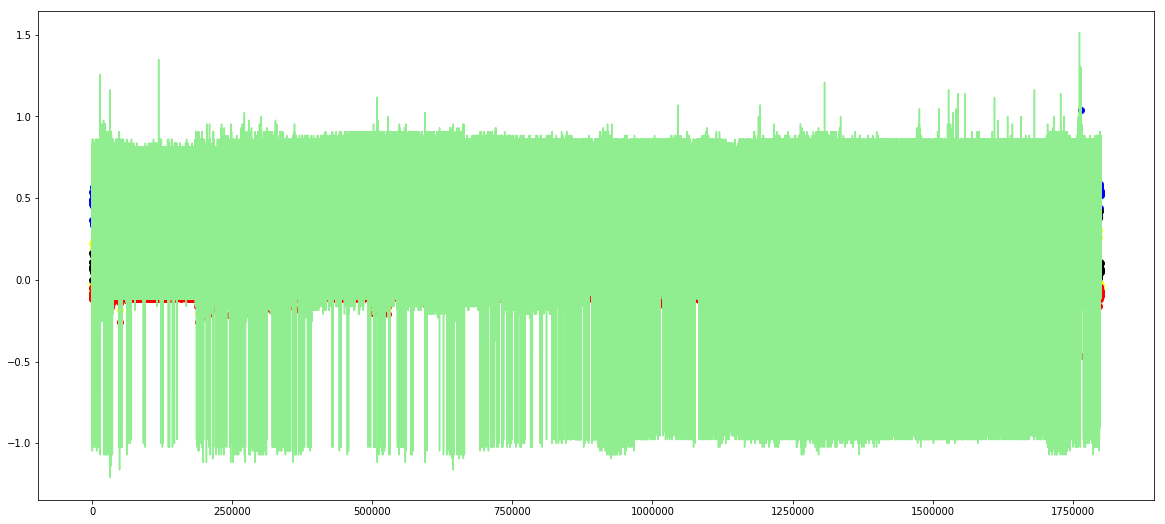

In [15]:
plt.scatter(previousResult['Q_i'], previousResult['Q_amp'],c='yellow')
plt.scatter(previousResult['R_i'], previousResult['R_amp'],c='blue')
plt.scatter(previousResult['S_i'], previousResult['S_amp'],c='red')
plt.scatter(previousResult['T_i'], previousResult['T_amp'],c='black')
plt.plot(subsignal,c='lightgreen')
plt.show()

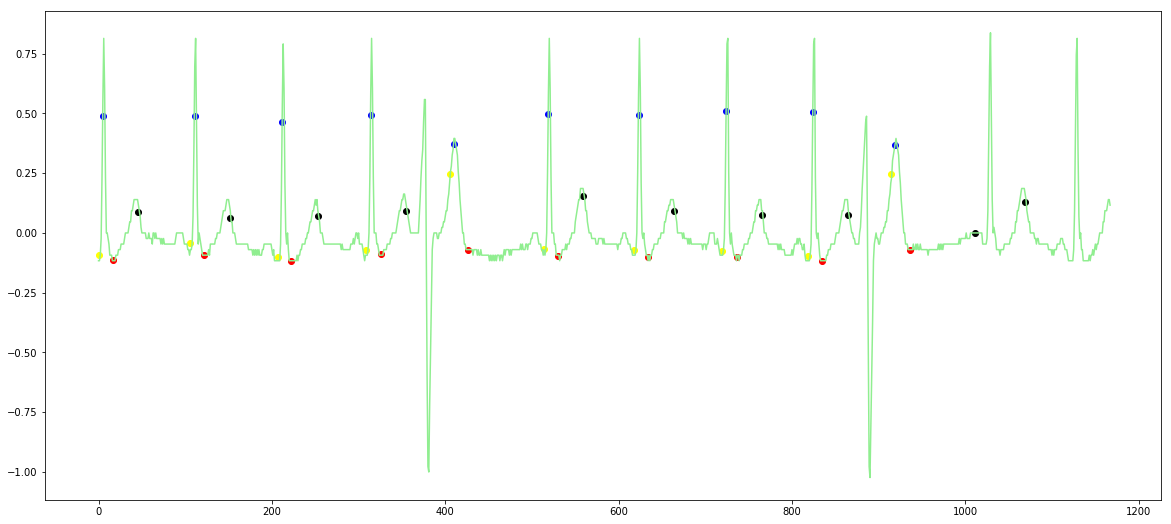

In [16]:
init = 45
end = 55
plt.plot(subsignal[int(previousResult['Q_i'][init]):int(previousResult['T_i'][end])],c='lightgreen')
plt.scatter(previousResult['Q_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['Q_amp'][init:end],c='yellow')
plt.scatter(previousResult['R_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['R_amp'][init:end],c='blue')
plt.scatter(previousResult['S_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['S_amp'][init:end],c='red')
plt.scatter(previousResult['T_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['T_amp'][init:end],c='black')
plt.show()

In [17]:
print('Q',previousResult['Q_i'][504],'R',previousResult['R_i'][504])
print('S',previousResult['S_i'][504],'T',previousResult['T_i'][504])
print('Q',previousResult['Q_i'][505],'R',previousResult['R_i'][505])
print('S',previousResult['S_i'][505],'T',previousResult['T_i'][505])
print(previousResult['T_i'][504]<previousResult['Q_i'][504])

Q 53353.0
R 53358.0
S 53369.0
T 54240.0
Q 53456.0
R 53461.0
S 53472.0
T 54346.0
False


In [18]:
print('Q',len(previousResult['Q_i']), len(previousResult['Q_amp']))
print('R',len(previousResult['R_i']), len(previousResult['R_amp']))
print('S',len(previousResult['S_i']), len(previousResult['S_amp']))
print('T',len(previousResult['T_i']), len(previousResult['T_amp']))

1800000
Q 16392 16392
R 16392 16392
S 16392 16392
T 16268 16268


In [19]:
def sortHeartBeats(signal) :
    iterations = max(len(signal['Q_i']),len(signal['T_i']))
    q,t,result = 0,0,None
    while q<iterations:
        qi,qamp = signal['Q_i'][q],signal['Q_amp'][q]
        ti,tamp = int(signal['T_i'][t]),signal['T_amp'][t]
        if(q+1<iterations) :
            qinext = signal['Q_i'][q+1]
        else :
            qinext = None
        if(qinext is not None and qinext<ti) :
            ti,tamp,t = None,None,t-1
        if ti is not None and ti<qi :
            t=t+1
            ti,tamp = int(signal['T_i'][t]),signal['T_amp'][t]
        if ti is not None and ti<qi :
            print("error en",q,"con t",t)
        dic = {'Q_i':int(qi),'Q_amp':qamp,
              'R_i':int(signal['R_i'][q]),'R_amp':signal['R_amp'][q],
              'S_i':int(signal['S_i'][q]),'S_amp':signal['S_amp'][q],
              'T_i':ti,'T_amp':tamp}
        if result is None :
            result = pd.DataFrame(dic, index=[q])
        else :
            result = pd.concat([result,  pd.DataFrame(dic, index=[q])])
        q,t=q+1,t+1
    print("q",q,"t",t)
    return result
sortBeats = sortHeartBeats(previousResult)
print(sortBeats)

q 16392 t 16268
          Q_amp      Q_i     R_amp      R_i     S_amp      S_i     T_amp  \
0     -0.041860       60  0.488372       65 -0.079070       76  0.106977   
1     -0.065116      159  0.488372      164 -0.097674      175  0.065116   
2     -0.106977      259  0.465116      264 -0.116279      275  0.074419   
3      0.223256      354  0.367442      359 -0.093023      376  0.000000   
4     -0.023256      468  0.534884      473 -0.051163      483  0.167442   
5     -0.097674      570  0.483721      575 -0.111628      587  0.079070   
6     -0.088372      670  0.465116      675 -0.116279      685  0.093023   
7      0.223256      763  0.353488      768 -0.083721      786  0.000000   
8     -0.037209      876  0.539535      881 -0.055814      893  0.153488   
9     -0.088372      979  0.516279      984 -0.111628      995  0.065116   
10    -0.088372     1079  0.465116     1084 -0.116279     1094  0.060465   
11    -0.106977     1179  0.483721     1184 -0.116279     1195  0.093023

In [37]:
def checkQRST(qrst) :
    shape = qrst.shape[0]
    x = 0
    while x<shape :
        if(qrst.iloc[x]["S_i"]-qrst.iloc[x]["Q_i"]<0) :
            print(qrst.iloc[x]["S_i"]-qrst.iloc[x]["Q_i"])
        x=x+1
checkQRST(sortBeats)

In [27]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(np.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(np.int64, addapt_numpy_int64)

In [63]:
sortBeats = sortBeats.assign(subject_id=int(subject_id)).assign(recorddate=recorddate)
sortBeats['QRTSOrder'] = sortBeats.index
def saveQRST(qrst) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    table = "waveformQRST"
    cur.execute("CREATE TABLE IF NOT EXISTS "+table+
            " (id serial PRIMARY KEY,"+
            "Q_amp real,"+
            "Q_i integer,"+
            "R_amp real,"+
            "R_i integer,"+
            "S_amp real,"+
            "S_i integer,"+
            "T_amp real,"+
            "T_i integer,"+
            "subject_id integer,recorddate character varying(255),QRTSOrder integer,"+
            'CONSTRAINT "uniqueQRST" UNIQUE (subject_id, recorddate, qrtsorder));')
    insert_statement = 'insert into '+table+' (%s) values %s'
    for index, row in qrst.iterrows():
        columns = row.keys()
        values = [row[column] for column in columns]
#        print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
        cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    conn.close()
saveQRST(sortBeats)